In [86]:
from pathlib import Path
import joblib
from tools.data_loader import get_data_loader
import torch
from tools.preprocessor import Preprocessor
from utility.survival import make_time_bins
matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                    'axes.titlesize': 'medium',
                    'legend.fontsize': 'small',
                    'font.size': 14.0,
                    'text.usetex': True,
                    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})
import config as cfg
import numpy as np
import pandas as pd
import random
from lifelines.statistics import logrank_test

from utility.plot import load_tf_color
TFColor = load_tf_color()

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# Setup precision
dtype = torch.float64
torch.set_default_dtype(dtype)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setup dataset
dataset_name = "proact"

P_VALUE_DECIMALS = 5
P_VALUE_THRESHOLD = 0.001

# Load data
dl = get_data_loader("proact").load_data()
train_dict, valid_dict, test_dict = dl.split_data(train_size=0.7, valid_size=0.1,
                                                  test_size=0.2, random_state=0)
n_events = dl.n_events

# Preprocess the data
cat_features = dl.cat_features
num_features = dl.num_features
event_cols = [f'e{i+1}' for i in range(n_events)]
time_cols = [f't{i+1}' for i in range(n_events)]
X_train = pd.DataFrame(train_dict['X'], columns=dl.columns)
X_valid = pd.DataFrame(valid_dict['X'], columns=dl.columns)
X_test = pd.DataFrame(test_dict['X'], columns=dl.columns)
preprocessor = Preprocessor(cat_feat_strat='mode', num_feat_strat='mean', scaling_strategy="standard")
transformer = preprocessor.fit(X_train, cat_feats=cat_features, num_feats=num_features,
                               one_hot=True, fill_value=-1)

# Load model
path = Path.joinpath(cfg.MODELS_DIR, f"mensa_{dataset_name}.pkl")
model = joblib.load(path)

# Make time bins
time_bins = make_time_bins(train_dict['T'], event=None, dtype=dtype).to(device)
time_bins = torch.cat((torch.tensor([0]).to(device), time_bins))

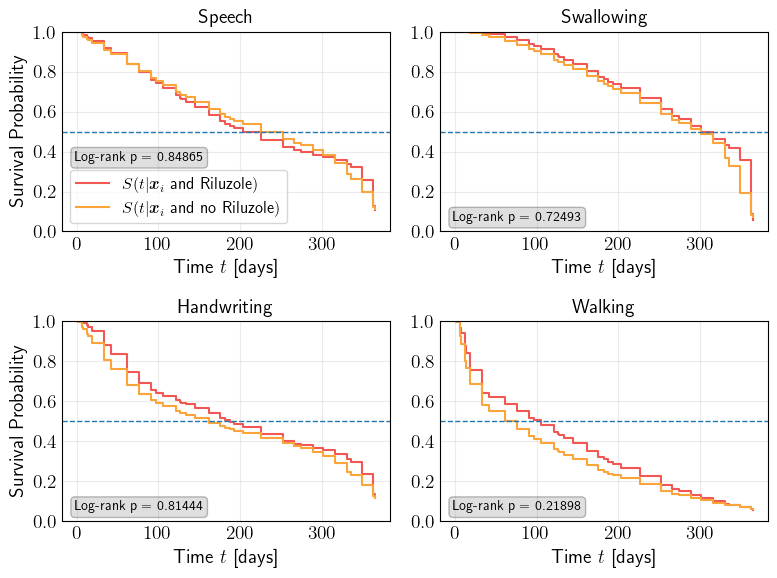

In [87]:
# Make prediction if patient takes Riluzole
sample_idx = 38
feature = "Subject_used_Riluzole"
X_test_sample = X_test.iloc[[sample_idx]]
X_test_sample_yes = X_test_sample.copy()
X_test_sample_yes[feature] = "Yes"
X_test_sample_no = X_test_sample.copy()
X_test_sample_no[feature] = "No"

# Groups
g1_idx = X_test.loc[X_test[feature] == "Yes"].index
g2_idx = X_test.loc[X_test[feature] == "No"].index
y_test_times_g1 = test_dict['T'][g1_idx]
y_test_times_g2 = test_dict['T'][g2_idx]
y_test_events_g1 = test_dict['E'][g1_idx]
y_test_events_g2 = test_dict['E'][g2_idx]

X_test_sample_yes = transformer.transform(X_test_sample_yes)
X_test_sample_no = transformer.transform(X_test_sample_no)

# Make predictions for the two counterfactuals
X_test_sample_yes_th = torch.tensor(X_test_sample_yes.to_numpy(), device=device, dtype=dtype)
X_test_sample_no_th = torch.tensor(X_test_sample_no.to_numpy(), device=device, dtype=dtype)
event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking']

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for event_id, ax in enumerate(axes.flatten()):
    riluzole_preds = model.predict(X_test_sample_yes_th, time_bins, risk=event_id).flatten()
    non_riluzole_preds = model.predict(X_test_sample_no_th, time_bins, risk=event_id).flatten()
    
    # Compute log-rank
    results = logrank_test(y_test_times_g1[:,event_id], y_test_times_g2[:,event_id],
                           event_observed_A=y_test_events_g1[:,event_id],
                           event_observed_B=y_test_events_g2[:,event_id])
    test_statistic = round(results.test_statistic, P_VALUE_DECIMALS)
    p_value = round(results.p_value, P_VALUE_DECIMALS)

    # Conditional formatting for p-value
    if p_value < P_VALUE_THRESHOLD:
        p_value_str = r"$<$" + "0.001"
    else:
        p_value_str = f'{p_value:.{P_VALUE_DECIMALS}f}'
    
    # Plot the survival curves
    ax.set_title(event_names[event_id])
    ax.step(time_bins.numpy(), riluzole_preds, where='post',
            label=r"$S(t|\bm{x}_{i}$" + " and Riluzole" + r"$)$", color=TFColor[0])
    ax.step(time_bins.numpy(), non_riluzole_preds, where='post',
            label=r"$S(t|\bm{x}_{i}$" + " and no Riluzole" + r"$)$", color=TFColor[1])
    
    # Add the test statistic and p-value in a box
    textstr = f'Log-rank p = {p_value}'
    props = dict(boxstyle='round', facecolor='gray', alpha=0.25)
    if event_id == 0:
        ax.text(0.04, 0.4, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props, linespacing=1.5)
    else:
        ax.text(0.04, 0.1, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props, linespacing=1.5)
        
    ax.axhline(y=0.5, linestyle="dashed", linewidth=1)
    
    ax.set_xlabel("Time $t$ [days]")
    if event_id % 2 == 0:
        ax.set_ylabel("Survival Probability")
    ax.set_ylim(0, 1)
    if event_id == 0:
        ax.legend(loc="lower left")
    ax.grid(True, alpha=0.25)
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both', length=0)
    
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/{dataset_name}_isd_riluzole.pdf", format='pdf', bbox_inches='tight')
plt.show()

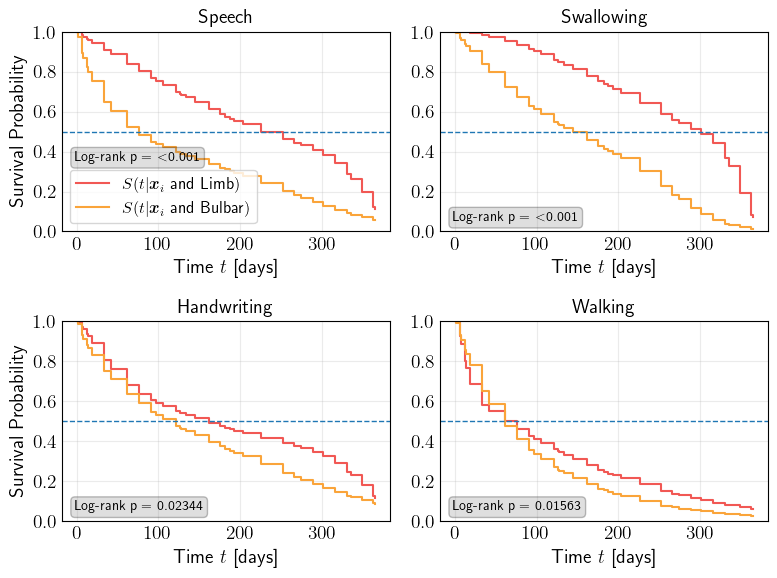

In [91]:
# Make prediction if patient has different site of onset
feature = "Site_of_Onset"
X_test_sample = X_test.iloc[[sample_idx]]
X_test_sample_limb = X_test_sample.copy()
X_test_sample_limb[feature] = "Limb"
X_test_sample_bulbar = X_test_sample.copy()
X_test_sample_bulbar[feature] = "Bulbar"

# Groups
g1_idx = X_test.loc[X_test[feature] == "Limb"].index
g2_idx = X_test.loc[X_test[feature] == "Bulbar"].index
y_test_times_g1 = test_dict['T'][g1_idx]
y_test_times_g2 = test_dict['T'][g2_idx]
y_test_events_g1 = test_dict['E'][g1_idx]
y_test_events_g2 = test_dict['E'][g2_idx]

X_test_sample_limb = transformer.transform(X_test_sample_limb)
X_test_sample_bulbar = transformer.transform(X_test_sample_bulbar)

# Make predictions for the two groups
X_test_sample_limb_th = torch.tensor(X_test_sample_limb.to_numpy(), device=device, dtype=dtype)
X_test_sample_bulbar_th = torch.tensor(X_test_sample_bulbar.to_numpy(), device=device, dtype=dtype)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for event_id, ax in enumerate(axes.flatten()):
    limb_preds = model.predict(X_test_sample_limb_th, time_bins, risk=event_id).flatten()
    bulbar_preds = model.predict(X_test_sample_bulbar_th, time_bins, risk=event_id).flatten()
    
    # Compute log-rank
    results = logrank_test(y_test_times_g1[:,event_id], y_test_times_g2[:,event_id],
                           event_observed_A=y_test_events_g1[:,event_id],
                           event_observed_B=y_test_events_g2[:,event_id])
    test_statistic = round(results.test_statistic, P_VALUE_DECIMALS)
    p_value = round(results.p_value, P_VALUE_DECIMALS)
    
    # Conditional formatting for p-value
    if p_value < P_VALUE_THRESHOLD:
        p_value_str = r"$<$" + "0.001"
    else:
        p_value_str = f'{p_value:.{P_VALUE_DECIMALS}f}'
        
    # Plot the survival curves
    ax.set_title(event_names[event_id])
    ax.step(time_bins.numpy(), limb_preds, where='post',
            label=r"$S(t|\bm{x}_{i}$" + " and Limb" + r"$)$", color=TFColor[0])
    ax.step(time_bins.numpy(), bulbar_preds, where='post',
            label=r"$S(t|\bm{x}_{i}$" + " and Bulbar" + r"$)$", color=TFColor[1])
    
    # Add the test statistic and p-value in a box
    textstr = f'Log-rank p = {p_value_str}'
    props = dict(boxstyle='round', facecolor='gray', alpha=0.25)
    if event_id == 0:
        ax.text(0.04, 0.4, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props, linespacing=1.5)
    else:
        ax.text(0.04, 0.1, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props, linespacing=1.5)
        
    ax.axhline(y=0.5, linestyle="dashed", linewidth=1)
    
    ax.set_xlabel("Time $t$ [days]")
    if event_id % 2 == 0:
        ax.set_ylabel("Survival Probability")
    ax.set_ylim(0, 1)
    if event_id == 0:
        ax.legend(loc="lower left")
    ax.grid(True, alpha=0.25)
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both', length=0)
    
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/{dataset_name}_isd_soo.pdf", format='pdf', bbox_inches='tight')
plt.show()

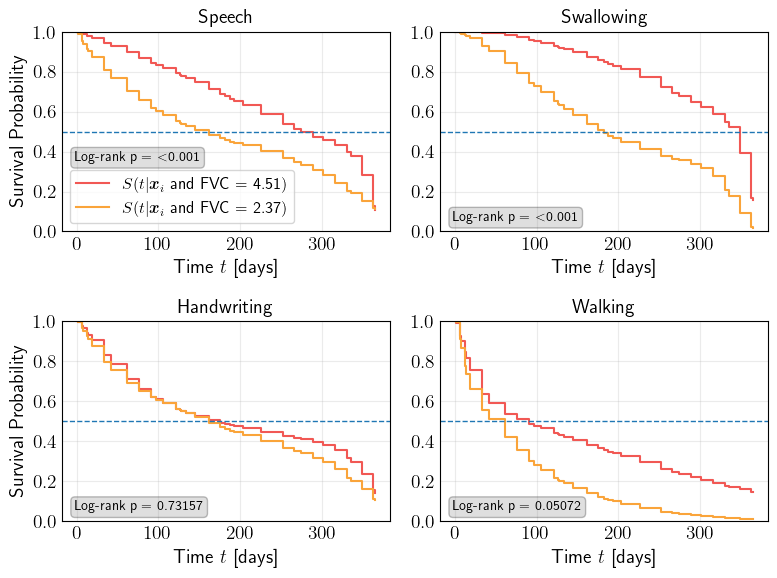

In [89]:
# Make prediction if patient is above or below mean FVC
feature = "FVC_Mean"
fvc_mean = dl.get_data()[0][feature].mean()
fvc_std = dl.get_data()[0][feature].std()

X_test_sample = X_test.iloc[[sample_idx]]
X_test_sample_above = X_test_sample.copy()
X_test_sample_above[feature] = (fvc_mean+fvc_std)
X_test_sample_below = X_test_sample.copy()
X_test_sample_below[feature] = (fvc_mean-fvc_std)

# Groups
g1_idx = X_test.loc[X_test[feature] >= (fvc_mean+fvc_std)].index
g2_idx = X_test.loc[X_test[feature] < (fvc_mean-fvc_std)].index
y_test_times_g1 = test_dict['T'][g1_idx]
y_test_times_g2 = test_dict['T'][g2_idx]
y_test_events_g1 = test_dict['E'][g1_idx]
y_test_events_g2 = test_dict['E'][g2_idx]

X_test_sample_above = transformer.transform(X_test_sample_above)
X_test_sample_below = transformer.transform(X_test_sample_below)

# Make predictions for the two groups
X_test_above_th = torch.tensor(X_test_sample_above.to_numpy(), device=device, dtype=dtype)
X_test_below_th = torch.tensor(X_test_sample_below.to_numpy(), device=device, dtype=dtype)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for event_id, ax in enumerate(axes.flatten()):
    fvc_above_preds = model.predict(X_test_above_th, time_bins, risk=event_id).mean(axis=0)
    fvc_below_preds = model.predict(X_test_below_th, time_bins, risk=event_id).mean(axis=0)
    
    # Compute log-rank
    results = logrank_test(y_test_times_g1[:,event_id], y_test_times_g2[:,event_id],
                           event_observed_A=y_test_events_g1[:,event_id],
                           event_observed_B=y_test_events_g2[:,event_id])
    p_value = round(results.p_value, P_VALUE_DECIMALS)
    
    # Conditional formatting for p-value
    if p_value < P_VALUE_THRESHOLD:
        p_value_str = r"$<$" + "0.001"
    else:
        p_value_str = f'{p_value:.{P_VALUE_DECIMALS}f}'
        
    # Plot the survival curves
    ax.set_title(event_names[event_id])
    ax.step(time_bins.numpy(), fvc_above_preds, where='post',
            label=r"$S(t|\bm{x}_{i}$" + f" and FVC " + r"=" + f" {round(fvc_mean+fvc_std, 2)}" + r"$)$", color=TFColor[0])
    ax.step(time_bins.numpy(), fvc_below_preds, where='post',
            label=r"$S(t|\bm{x}_{i}$" + f" and FVC " + r"=" + f" {round(fvc_mean-fvc_std, 2)}" + r"$)$", color=TFColor[1])
    
    # Add the test statistic and p-value in a box
    textstr = f'Log-rank p = {p_value_str}'
    props = dict(boxstyle='round', facecolor='gray', alpha=0.25)
    if event_id == 0:
        ax.text(0.04, 0.4, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props, linespacing=1.5)
    else:
        ax.text(0.04, 0.1, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props, linespacing=1.5)
        
    ax.axhline(y=0.5, linestyle="dashed", linewidth=1)
    
    ax.set_xlabel("Time $t$ [days]")
    if event_id % 2 == 0:
        ax.set_ylabel("Survival Probability")
    ax.set_ylim(0, 1)
    if event_id == 0:
        ax.legend()
    ax.grid(True, alpha=0.25)
    
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both', length=0)
    
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/{dataset_name}_isd_fvc.pdf", format='pdf', bbox_inches='tight')
plt.show()

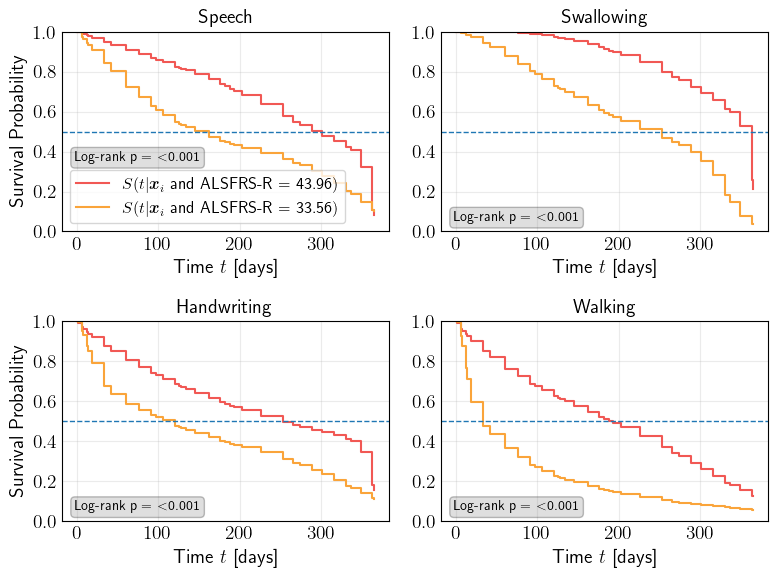

In [90]:
# Make prediction if patient has high/low baseline mean ALSFRS score
feature = "ALSFRS_R_Total"
alsfrs_mean = dl.get_data()[0][feature].mean()
alsfrs_std = dl.get_data()[0][feature].std()

X_test_sample = X_test.iloc[[sample_idx]]
X_test_sample_above = X_test_sample.copy()
X_test_sample_above[feature] = (alsfrs_mean+alsfrs_std)
X_test_sample_below = X_test_sample.copy()
X_test_sample_below[feature] = (alsfrs_mean-alsfrs_std)

# Groups
g1_idx = X_test.loc[X_test[feature] >= (alsfrs_mean+alsfrs_std)].index
g2_idx = X_test.loc[X_test[feature] < (alsfrs_mean-alsfrs_std)].index
y_test_times_g1 = test_dict['T'][g1_idx]
y_test_times_g2 = test_dict['T'][g2_idx]
y_test_events_g1 = test_dict['E'][g1_idx]
y_test_events_g2 = test_dict['E'][g2_idx]

X_test_sample_above = transformer.transform(X_test_sample_above)
X_test_sample_below = transformer.transform(X_test_sample_below)

# Make predictions for the two groups
X_test_above_th = torch.tensor(X_test_sample_above.to_numpy(), device=device, dtype=dtype)
X_test_below_th = torch.tensor(X_test_sample_below.to_numpy(), device=device, dtype=dtype)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for event_id, ax in enumerate(axes.flatten()):
    alsfrs_above_preds = model.predict(X_test_above_th, time_bins, risk=event_id).mean(axis=0)
    alsfrs_below_preds = model.predict(X_test_below_th, time_bins, risk=event_id).mean(axis=0)
    
    # Compute log-rank
    results = logrank_test(y_test_times_g1[:,event_id], y_test_times_g2[:,event_id],
                           event_observed_A=y_test_events_g1[:,event_id],
                           event_observed_B=y_test_events_g2[:,event_id])
    p_value = round(results.p_value, P_VALUE_DECIMALS)
    
    # Conditional formatting for p-value
    if p_value < P_VALUE_THRESHOLD:
        p_value_str = r"$<$" + "0.001"
    else:
        p_value_str = f'{p_value:.{P_VALUE_DECIMALS}f}'
        
    # Plot the survival curves
    ax.set_title(event_names[event_id])
    ax.step(time_bins.numpy(), alsfrs_above_preds, where='post',
            label=r"$S(t|\bm{x}_{i}$" + f" and ALSFRS-R " + r"=" + f" {round(alsfrs_mean+alsfrs_std, 2)}" + r"$)$", color=TFColor[0])
    ax.step(time_bins.numpy(), alsfrs_below_preds, where='post',
            label=r"$S(t|\bm{x}_{i}$" + f" and ALSFRS-R " + r"=" + f" {round(alsfrs_mean-alsfrs_std, 2)}" + r"$)$", color=TFColor[1])
    
    # Add the test statistic and p-value in a box
    textstr = f'Log-rank p = {p_value_str}'
    props = dict(boxstyle='round', facecolor='gray', alpha=0.25)
    if event_id == 0:
        ax.text(0.04, 0.4, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props, linespacing=1.5)
    else:
        ax.text(0.04, 0.1, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props, linespacing=1.5)
        
    ax.axhline(y=0.5, linestyle="dashed", linewidth=1)
    
    ax.set_xlabel("Time $t$ [days]")
    if event_id % 2 == 0:
        ax.set_ylabel("Survival Probability")
    ax.set_ylim(0, 1)
    if event_id == 0:
        ax.legend()
    ax.grid(True, alpha=0.25)
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both', length=0)
    
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/{dataset_name}_isd_alsfrs.pdf", format='pdf', bbox_inches='tight')
plt.show()